In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
listings = pd.read_csv('listings.csv')

In [4]:
# Copy the dataframe
list_clean = listings.copy()

In [5]:
# First, let's drop some columns that are not useful for analysis
cols = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
       'host_thumbnail_url', 'host_picture_url', 'country', 'country_code', 'neighbourhood',
       'smart_location', 'street', 'market', 'first_review', 'last_review', 'state', 'calendar_last_scraped',
       'calendar_updated', 'city', 'scrape_id', 'last_scraped', 'space', 'host_neighbourhood', 
        'neighborhood_overview', 'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count']
list_clean.drop(cols, axis=1, inplace=True)

In [6]:
cols = list_clean.columns[list_clean.isnull().sum()/list_clean.shape[0] > 0.5]
list_clean.drop(cols, axis=1, inplace=True)

In [7]:
# fix some datatype errors, extract numbers and change to int type
cols = ['host_response_rate', 'host_acceptance_rate', 'price', 'cleaning_fee', 'extra_people']
for col in cols:
    list_clean[col] = list_clean[col].str.extract(r'(\d+)')
    list_clean[col] = list_clean[col].astype('float128').astype('Int64')
list_clean[cols].dtypes

host_response_rate      Int64
host_acceptance_rate    Int64
price                   Int64
cleaning_fee            Int64
extra_people            Int64
dtype: object

In [8]:
# Change datatype for host_since
list_clean['host_since'] = pd.to_datetime(list_clean.host_since)
temp = pd.to_datetime('12/31/2019')

list_clean['host_len'] = list_clean.host_since.apply(lambda x: pd.Timedelta(temp-x).days)
list_clean = list_clean.drop('host_since', axis=1)

In [9]:
# extract the number of amenities 
list_clean['n_amenities'] = list_clean['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
list_clean.drop('amenities', axis=1, inplace=True)

In [10]:
df_num = list_clean.select_dtypes(include=['int', 'float'])

In [11]:
# fill na for the columns
int_fillmean = lambda x: x.fillna(round(x.mean()))
df_num = df_num.apply(int_fillmean, axis=0)
df_num = df_num.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)

In [12]:
# we can see that some listed price are 1 dollar, which is not intuitive
df_num = df_num[df_num['price'] != 1]
# we will also exlude some outliers of the price > 1.5 IQR
df_num = df_num[df_num['price'] < 423]

In [13]:
# The categorical features
df_cat = list_clean.select_dtypes(include=['object'])
# drop description lines
df_cat = df_cat.drop(['name', 'summary', 'description', 'experiences_offered', 'host_about', 
                      'host_verifications', 'host_name'], axis=1)

In [14]:
# find the not na rows with True
df_cat['with_inter'] = df_cat.interaction.notna().astype('object')
df_cat['with_access']= df_cat.access.notna().astype('object')
df_cat['with_rules'] = df_cat.house_rules.notna().astype('object')
df_cat['with_transit'] = df_cat.transit.notna().astype('object')
df_cat = df_cat.drop(['transit', 'access', 'interaction', 'house_rules'], axis=1)

In [15]:
df_cat = pd.concat([df_cat, list_clean.price], axis=1)
df_cat = df_cat[df_cat['price'] != 1]
df_cat = df_cat[df_cat['price'] < 423]

In [16]:
# get dummy values for categorical features
df_cat_dummies = pd.get_dummies(df_cat.iloc[:,:-1], dummy_na=False)

In [17]:
# concatenate the model df
df_mod = pd.concat([df_num, df_cat_dummies], axis=1)

In [18]:
# get the feature and label
X = df_mod.drop('price', axis=1)
y = df_mod['price']

In [19]:
# There are two many features, let's select top 30 features with REF model
n = np.arange(5, 100, 5)
model = LinearRegression()
R2 = []
#Initializing RFE model
for num in n:
    rfe = RFE(model, num)
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X,y)  
    #Fitting the data to model
    model.fit(X_rfe,y)
    # generate new feature matrix
    X_new = X.iloc[:,rfe.support_]
    # split training and testing model
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    # fit the data
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    R2.append(metrics.r2_score(y_test, pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these

In [20]:
ind = np.array(R2).argmax()
f_n = n[ind]
rfe = RFE(model, f_n)
X_rfe = rfe.fit_transform(X,y) 
model.fit(X_rfe,y)
X_new = X.iloc[:,rfe.support_]
print('{} features are selected'.format(f_n))

95 features are selected


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=95 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
# split training and testing model
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [22]:
# fit the data
lm = LinearRegression()
lm.fit(X_train, y_train)
pred = lm.predict(X_test)

In [23]:
mse = metrics.mean_squared_error(y_test, pred)
r_square = metrics.r2_score(y_test, pred)

print('Mean absolute error is {}'.format(mse))
print('R^2 is {}'.format(r_square))

Mean absolute error is 2599.759883065739
R^2 is 0.6675173286542573


In [24]:
# create a function to visualize the distribution of the prediction and the test
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    plt.figure(figsize=(10, 8))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()

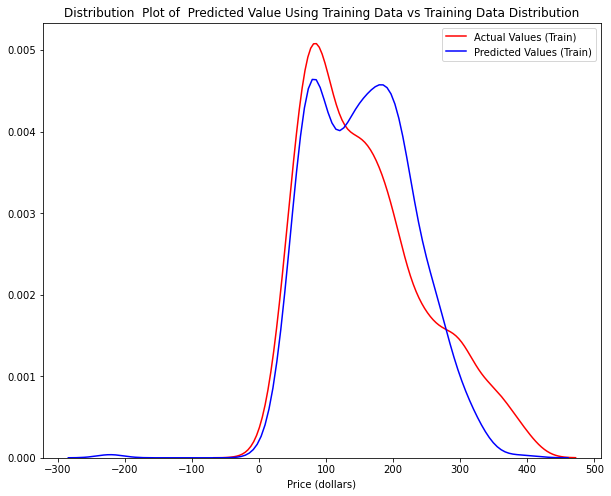

In [25]:
# Visualize the results
DistributionPlot(y_test, pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

## Cross-Validation

In [26]:
Rcross = cross_val_score(lm, X_new, y, cv=10)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.506030708254247 and the standard deviation is 0.14522003374178077


## Ridge Regression


In [27]:
# Ridge model
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 10, 20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RR_square.append(RigeModel.score(X_test, y_test))
    RR_train.append(RigeModel.score(X_train, y_train))

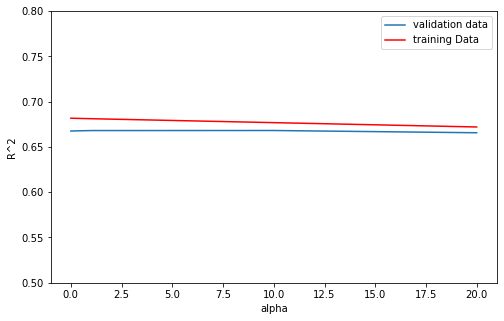

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square, label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0.5, 0.8)
plt.legend();

In [29]:
# Choose a ridge
RigeModel = Ridge(alpha=5) 
RigeModel.fit(X_train, y_train)
rr_pred = RigeModel.predict(X_test)
print('r2 score is: {}'.format(RigeModel.score(X_test, y_test)))

r2 score is: 0.6685482044775237


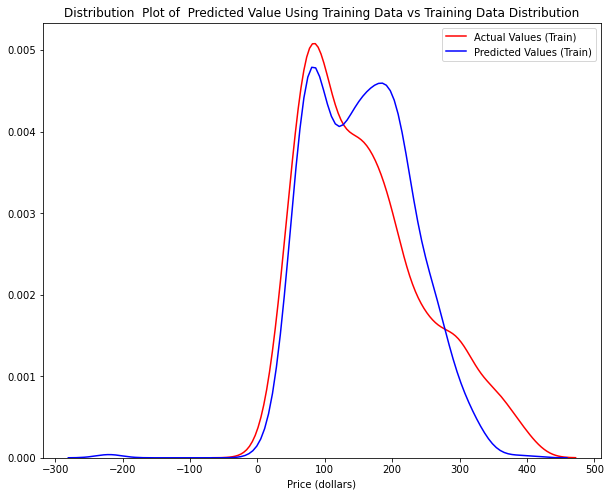

In [30]:
# Visualize the results
DistributionPlot(y_test, rr_pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

In [31]:
coef_df = pd.DataFrame(data=list(lm.coef_), index=X_new.columns).reset_index().rename(columns={'index': 'Var', 0: 'Coef'})

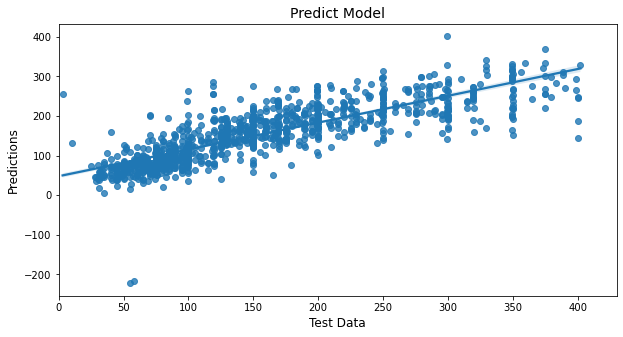

In [32]:
# Predicted prive VS. actural price 
plt.figure(figsize=(10,5))
sns.regplot(x=y_test, y=rr_pred, color=sns.color_palette()[0])
plt.xlim(0, 430)
plt.title('Predict Model', fontsize=14)
plt.xlabel('Test Data', fontsize=12)
plt.ylabel('Predictions', fontsize=12);

In [33]:
# Neighboorhood on price
neighborhoods = coef_df[coef_df.Var.str.contains('neighbourhood')].sort_values(by='Coef', ascending=False)
neighborhoods['Var'] = neighborhoods['Var'].apply(lambda x: x.split('_')[2])

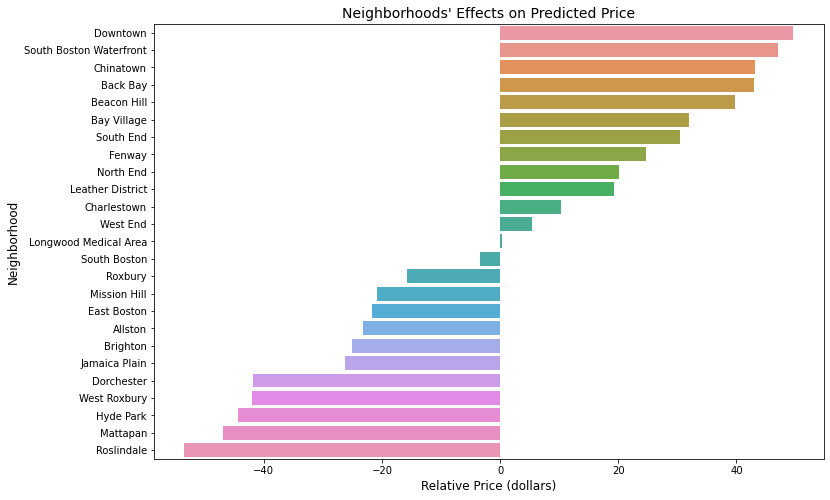

In [35]:
plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhoods, x='Coef', y='Var')
plt.xlabel('Relative Price (dollars)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title("Neighborhoods' Effects on Predicted Price", fontsize=14);

In [36]:
# Property type on Price
property_type = coef_df[coef_df.Var.str.contains('property_type')].sort_values(by='Coef', ascending=False)
property_type['Var'] = property_type['Var'].apply(lambda x: x.split('_')[2])

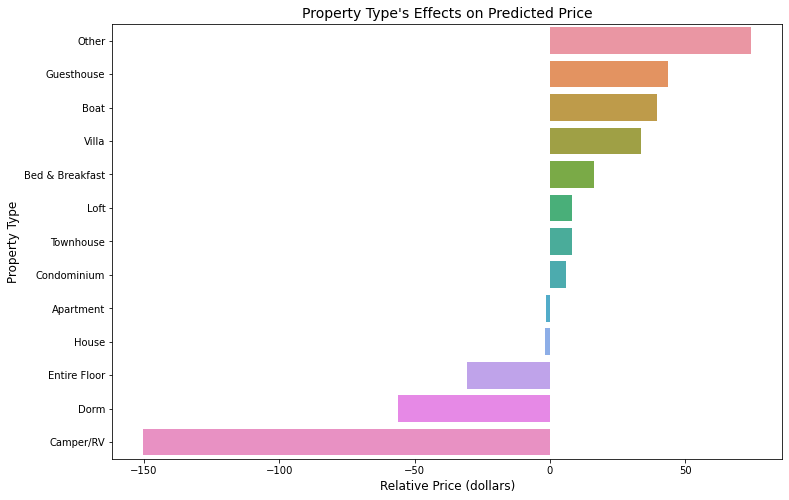

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(data=property_type, x='Coef', y='Var')
plt.xlabel('Relative Price (dollars)', fontsize=12)
plt.ylabel('Property Type', fontsize=12)
plt.title("Property Type's Effects on Predicted Price", fontsize=14);

## Analysis

* According to our model, every additional bedroom will cost extra 28.5 dollars, while each additional bathroom will cost extra 2.3 dollars. Each additional guests will cost 6 dollars more.

* Real bed costs more than alternative options.

* Neighbourhood areas strongly bias the price.

* Superhosts' listings are 6 dollars more expensive on average.

* Property types strongly affect the price. For example: a camp/RV will cost 150 dollars less on average but a boat will cost 39.7 dollars more on average.

* Entire room on average will cost 76.6 more than a shared-room.

* The more strict the cacellation policy is, the more expensive the listing will be. Listings have strict cancellation policy are tend to be more expensive and popular.